 # Systems:
 - Gene network switch (pg 120, Ch 4.3)
 - Can also do repressilator model w/ 6 equations?
 - Morris-Lecar Model (pg 154 Ch 5.5 & end of Ch 3.4)
 - 1D ODE in Ch 5.1
 - Maybe check out linear systems of diff eq in 5.3.3 pg 145
 
 #### misc
 - MSE: https://stackoverflow.com/questions/16774849/mean-squared-error-in-numpy
 - colorednoise library for different noise `cn.powerlaw_psd_gaussian(beta, 10000)* (sigmaVal + 0.03)` for noise that follows the np.normal thing for gaussian noise and a bit lower for pink. `* 0.03` to correct standard deviation. Not perfect though
 - https://github.com/dynamicslab/pysindy/issues/171
 - https://github.com/dynamicslab/pysindy/issues/132
 - https://github.com/dynamicslab/pysindy/issues/101 May be relevant for hill functions
 
## To-do
##### GENERAL
 - watch pySINDy tutorials to learn how to use it
 - Hadlock lab cloud computing work?

##### TOPICAL GOALS
 - Issue with ODE solver where it blows up. Numerical error dividing small values or soln has huge derivative?? Need to fix, lengthens computation time and lowers accuracy of model.
  - ODEint warning is from a Stiff Equation. "hole" or jump in our solution points that occurs from having too wide timesteps
 - May want to look into other integration methods to resolve stiffness https://docs.scipy.org/doc/scipy-1.7.1/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp Radau and BDF are recomended but have issues (see 7/17 entry). Using atol and rtol for small stepsize also brings numerical error (too small or too big or divide by zero)
 - model.simulate has an `interpolator` parameter. See issue #171 for an application with cubicspline


##### 7/17
Ran sigma test again with BDF integration and 5k timesteps. Ran for ~2.5hrs and error when calculating MSE. Error comes from differing array shapes which stems from some solution "sheets" in the simulation stack not being 'complete'. BDF error? Atleast there ain't any Excess Work warnings :')
    
##### 7/19
Check out SINDy-PI
solve explicit ODE to implicit ODE
Add fraction term to LHS, add xdot to fraction, multiply out denom, move terms back over to RHS and simplify. ezpz

investigate ICs in Ex-System to try to diagnose integration error
Try to find terminal for jupyter notebook to observe errors directly to know if kernel is having issues or just taking a long time to run

MSE, divide by number of IC too
    
https://scicomp.stackexchange.com/questions/40130/solve-ivp-from-scipy-does-not-integrate-the-whole-range-of-tspan
https://stackoverflow.com/questions/69352999/solve-ivp-from-scipy-does-not-integrate-the-whole-range-of-tspan
Explanation for Radau/BDF not integrating fully?

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
import pysindy as ps
from sklearn.metrics import mean_squared_error
import colorednoise as cn
# from matplotlib.cm import rainbow
# from scipy.io import loadmat
# V correct RMSE method, 6 is prefactor
# rmse_test = np.sqrt(np.square(np.subtract(A, B)).sum()) / 6


In [89]:
#### test cell
num = 2
mu = np.zeros(num)
sigma = np.zeros((num, num))
sigmaVal = .9
np.fill_diagonal(sigma, sigmaVal)
#sigma
#result = np.random.multivariate_normal(mu, sigma**2, (100, 100))
#noise123 = netswitch_train_multi + result
#print(np.max(result))
#print(np.random.rand(n_of_ic, 2) * 10)
#A = [1, 2, 3]
#B = [4, 5, 6]
# testing of different MSE methods
#print(mean_squared_error(A, B))
#print(np.square(np.subtract(netswitch_train_multi, noise123)).mean())
#print(((np.array(A) - B) ** 2).mean(axis=None))

# accurate enough for noise? Pink noise behaving weird
beta = 0 # the exponent
samples = 2**18 # number of samples to generate
y = cn.powerlaw_psd_gaussian(beta, (100, 400, 2)) * sigmaVal + 0.02
#print(np.max(y))
"""
y_list = []
result_list = []
for i in range(1000):
    y_temp = (cn.powerlaw_psd_gaussian(beta, (100, 100, 2)) * (sigmaVal + 0.03))
    result_temp = (np.random.multivariate_normal(mu, sigma**2, (100, 100)))
    y_list.append(y_temp)
    result_list.append(result_temp)
print(f"colorednoise mean = {np.mean(y_list)}")
print(f"multivariate_normal mean = {np.mean(result_list)}")
"""
train_array = np.asarray(netswitch_train_multi, dtype=object)
#sim_array = np.stack(simulations)
print((simulations[17]).shape)
for i in range(len(simulations)):
    print(f"index {i}, shape {simulations[i].shape}")
print("-------------------------------------------------------------------------------------------------------------------")
print((train_array.shape))
np.square(np.subtract(train_array, np.asarray(sim_array))).sum() / (len(tvals) * feature_count)

(5000, 2)
index 0, shape (5000, 2)
index 1, shape (5000, 2)
index 2, shape (5000, 2)
index 3, shape (5000, 2)
index 4, shape (5000, 2)
index 5, shape (5000, 2)
index 6, shape (5000, 2)
index 7, shape (5000, 2)
index 8, shape (5000, 2)
index 9, shape (5000, 2)
index 10, shape (5000, 2)
index 11, shape (5000, 2)
index 12, shape (5000, 2)
index 13, shape (5000, 2)
index 14, shape (5000, 2)
index 15, shape (5000, 2)
index 16, shape (5000, 2)
index 17, shape (5000, 2)
index 18, shape (5000, 2)
index 19, shape (5000, 2)
index 20, shape (5000, 2)
index 21, shape (5000, 2)
index 22, shape (5000, 2)
index 23, shape (5000, 2)
index 24, shape (5000, 2)
index 25, shape (5000, 2)
index 26, shape (5000, 2)
index 27, shape (5000, 2)
index 28, shape (5000, 2)
index 29, shape (1695, 2)
index 30, shape (5000, 2)
index 31, shape (5000, 2)
index 32, shape (5000, 2)
index 33, shape (5000, 2)
index 34, shape (5000, 2)
index 35, shape (5000, 2)
index 36, shape (5000, 2)
index 37, shape (5000, 2)
index 38, sh

ValueError: operands could not be broadcast together with shapes (300,5000,2) (300,) 

## Gene Network Switch

In [4]:
# contains functions + basic parameters
a_u, a_v = 1, 1
beta, gamma = 2, 2
dudt = lambda u, v: -u + (a_u / (1+v**beta))
dvdt = lambda u, v: -v + (a_v / (1+u**gamma))
sigma = 0.01
sigma_list = np.linspace(0.001, 0.8, 10)
netswitch = lambda t, x: np.array([dudt(x[0], x[1]), dvdt(x[0], x[1])])
# 0-5 minus some value between 0-1, no negatives for IC?
n_of_ic = 1000
u_ic = np.random.random(size=n_of_ic) * 5 - np.random.random(size=n_of_ic)
v_ic = np.random.random(size=n_of_ic) * 5 - np.random.random(size=n_of_ic)

def plot_data_and_derivative(x, dt, deriv):
    feature_name = ["u", "v"]
    plt.figure(figsize=(20, 5))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.plot(x[:, i], label=feature_name[i])
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
    x_dot = deriv(x, t=dt)
    plt.figure(figsize=(20, 5))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.plot(x_dot[:, i], label=r"$\dot{" + feature_name[i] + "}$")
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
library_functions = [
    lambda x: x,
    lambda x: 1 / (1 + x**1),
    lambda x: 1 / (1 + x**2),
    lambda x: 1 / (1 + x**3),
    lambda x: 1 / (1 + x**4),
    lambda x: 1 / (1 + x**5)
]
library_function_names = [
    lambda x: x,
    lambda x: '1/(1 + ' + x + '^1)',
    lambda x: '1/(1 + ' + x + '^2)',
    lambda x: '1/(1 + ' + x + '^3)',
    lambda x: '1/(1 + ' + x + '^4)',
    lambda x: '1/(1 + ' + x + '^5)'
]
netswitch_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

(u)' = -1.112 u + 5.802 1/(1 + u^2) + 4.783 1/(1 + v^2) + -4.630 1/(1 + u^3) + -3.122 1/(1 + v^3) + -8.863 1/(1 + u^4) + -5.796 1/(1 + v^4) + 7.845 1/(1 + u^5) + 5.346 1/(1 + v^5)
(v)' = -1.122 v + 5.139 1/(1 + u^2) + 5.554 1/(1 + v^2) + -3.459 1/(1 + u^3) + -4.611 1/(1 + v^3) + -5.523 1/(1 + u^4) + -8.604 1/(1 + v^4) + 5.135 1/(1 + u^5) + 7.753 1/(1 + v^5)
(5000, 2)


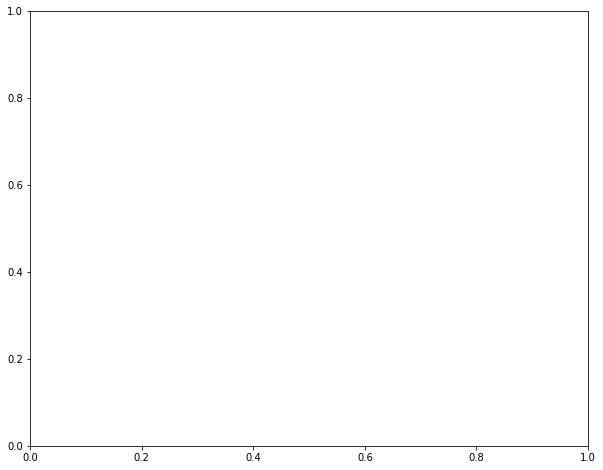

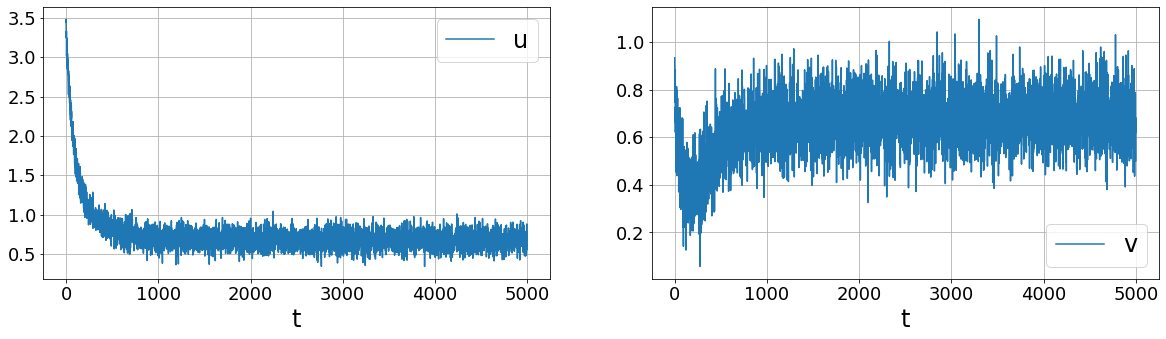

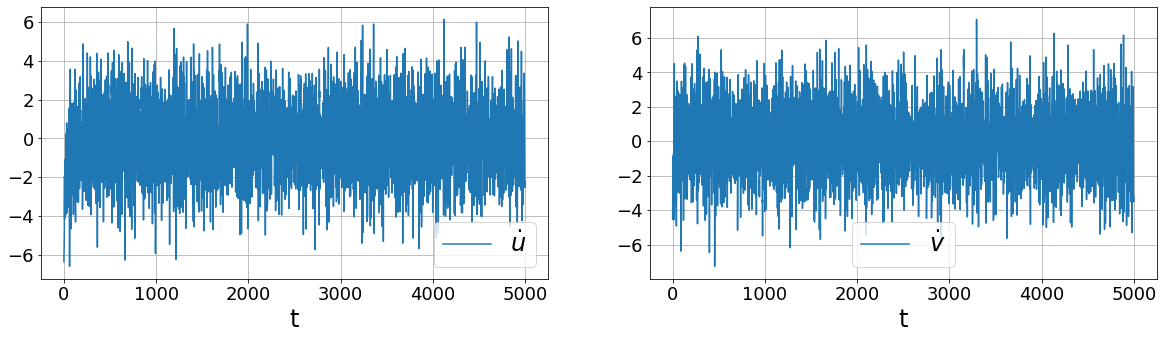

In [9]:
# Dynamic System #1 DMiB page 120
# Gene Network switch
u0 = 1
v0 = 1
T = 20
dt = 0.01
trange = np.array([0, T])
#tvals = np.arange(0, T + dt, dt)
tvals = np.linspace(0, T, 500)
fig, axs = plt.subplots(figsize=(10,8))
netswitch_x0s = (np.random.rand(n_of_ic, 2) * 5 - np.random.rand(n_of_ic, 2))
netswitch_train_multi = []
n_of_ic = 1000

# creation of data/solution
for i in range(n_of_ic): 
    #x0 = np.array([u_ic[i], v_ic[i]])
    # solve Sys #1
    #soln = solve_ivp(netswitch, trange, x0, t_eval=tvals)
    #uSoln = soln.y[0,:].reshape(-1,1)
    #vSoln = soln.y[1,:].reshape(-1,1)
    # graph 
    #axs.plot(tvals, uSoln, "r", label="$u$", **plot_kws)
    #axs.plot(tvals, vSoln, "b", label="$v$", **plot_kws)
    
    # phase portrait
    #axs.plot(uSoln, vSoln, label=f"$u_0 = {round(v_ic[i], 3)}, v_0 = {round(v_ic[i], 3)}$", alpha=0.4)
    
    # pySINDy
    # data creation
    netswitch_train_temp = solve_ivp(
        netswitch, trange, netswitch_x0s[i], t_eval=tvals
    ).y.T
    noise = np.random.normal(0, .1, netswitch_train_temp.shape)
    netswitch_train_multi.append(netswitch_train_temp + noise)
    #netswitch_train_multi.append(netswitch_train_temp + np.random.normal(0, 0.015, netswitch_train_temp.shape))
#axs.legend()
#axs.set(xlabel="u", ylabel="$v$")
#plt.show()
#print(netswitch_train_multi)

sparse_regression_optimizer = ps.STLSQ(threshold=0.5)
model = ps.SINDy(feature_names=['u', 'v'], optimizer=sparse_regression_optimizer, feature_library=netswitch_library)
model.fit(netswitch_train_multi, t=dt, multiple_trajectories=True)
model.print()
plot_data_and_derivative(netswitch_train_multi[0], dt, ps.SmoothedFiniteDifference()._differentiate)
netswitch_sim = model.simulate(np.random.rand(2) * 5 - np.random.rand(2), t=tvals)
print(netswitch_sim.shape)
#axs.plot(tvals, netswitch_sim[, "b", label="$v$", **plot_kws)
#netswitch_train_multi = []
#MSE_result = []
#for j in range(len(sigma_list)):
#    for i in range(n_of_ic): 
#        netswitch_train_temp = solve_ivp(
#            netswitch, trange, netswitch_x0s[i], t_eval=tvals
#        ).y.T
#        noise = np.random.normal(0, sigma_list[j], netswitch_train_temp.shape)
#        netswitch_train_multi.append(netswitch_train_temp + noise)
#    sparse_regression_optimizer = ps.STLSQ(threshold=0.7)
#    model = ps.SINDy(feature_names=['u', 'v'], optimizer=sparse_regression_optimizer, feature_library=netswitch_library)
#    model.fit(netswitch_train_multi, t=dt, multiple_trajectories=True)
#    netswitch_sim = model.simulate(np.random.rand(2) * 5 - np.random.rand(2), t=tvals)
    test = netswitch_train_multi[0][:, 0]

In [ ]:
test
htest = 1 / (1+test**5)
#plt.scatter(test, htest)
feature_count =2
netswitch_x0s = (np.random.rand(n_of_ic, feature_count) * 5 - np.random.rand(n_of_ic, feature_count))
model = ps.SINDy(feature_names=['u', 'v'], optimizer=ps.STLSQ(threshold=0.7), feature_library=netswitch_library)
model.fit(list(netswitch_train_multi), t=dt, multiple_trajectories=True)
model.print()
netswitch_sim = model.simulate(netswitch_x0s[0], t=tvals, integrator="odeint")
test2 = netswitch_sim[:, 0]
htest2 = 1 / (1+test2**5)
plt.scatter(tvals, test2)

In [5]:
first = netswitch_train_multi[0][0]
#print(netswitch_train_multi[0].shape)
#print(first.dot(first))
A = np.array([[3, 2],[4, 6],[1, 5]])
B = np.array([[3.2, 1.8],[3.4, 7.3],[.9, 5.1]])
testarr = np.array([[-.2, .2],[.6, -1.3],[.1, -.1]])
manualrmse = np.sqrt(testarr[:,0].dot(testarr[:,0])+testarr[:,1].dot(testarr[:,1])) / 6
computerrmse = mean_squared_error(A, B, squared=False)
print(manualrmse)
print(computerrmse)
print(A[:, 1].dot(A[:, 1]))
# V correct RMSE method, 6 is prefactor
rmse_test = np.sqrt(np.square(np.subtract(A, B)).sum()) / 6

print(np.sqrt(np.square(np.subtract(A, B)).sum()) / 6)
diff = np.subtract(A, B)
np.sqrt(diff[:,0].dot(diff[:,0])+diff[:,1].dot(diff[:,1]))

0.24438130497691968
0.5656309304000191
65
0.24438130497691965


1.466287829861518

In [ ]:
# test of model w/ varying sigma
T = 20
dt = 0.01
trange = np.array([0, T])
#tvals = np.arange(0, T + dt, dt)
tvals = np.linspace(0, T, 400)
n_of_ic = 30
feature_count = 2
fig, axs = plt.subplots(figsize=(10,8))
netswitch_x0s = (np.random.rand(n_of_ic, feature_count) * 5 - np.random.rand(n_of_ic, feature_count))
sigma = 0.01
sigma_list = np.linspace(0.001, 0.6, 20)
mu = np.zeros(feature_count)
sparse_regression_optimizer = ps.STLSQ(threshold=0.5)
MSE_list = []
netswitch_train_multi = []
integrator_keywords = {}
# 0 for white, 1 for pink, 2 for brown
beta = 0
#integrator_keywords['full_output'] = True
#integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
#integrator_keywords['atol'] = 1e-12

print(integrator_keywords)

# creation of TRUE data/solution
for i in range(n_of_ic):     
    netswitch_train_temp = solve_ivp(
        netswitch, trange, netswitch_x0s[i], t_eval=tvals
    ).y.T
    netswitch_train_multi.append(netswitch_train_temp)
print(len(netswitch_train_multi))
print(netswitch_train_multi[0].shape)
# may need to use np.zeros
rmse = np.sqrt(np.square(netswitch_train_multi).sum()) / (len(tvals) * feature_count)
print(f"RMSE = {rmse}")
# train models
for j in range(len(sigma_list)):
    sigma = np.zeros((feature_count, feature_count))
    sigmaVal = sigma_list[j]
    np.fill_diagonal(sigma, sigmaVal)
    print(sigmaVal)
    #noise = np.random.multivariate_normal(mu, sigma**2, (n_of_ic, len(tvals)))
    noise = cn.powerlaw_psd_gaussian(beta, (n_of_ic, len(tvals), feature_count)) * (sigmaVal + 0.03)
    model = ps.SINDy(feature_names=['u', 'v'], optimizer=sparse_regression_optimizer, feature_library=netswitch_library)
    model.fit(list(netswitch_train_multi + noise), t=dt, multiple_trajectories=True)
    simulations = []
    # create simulations list to hold simulated data for corresponding IC
    for k in range(n_of_ic):
        # problem area with warnings
        netswitch_sim = model.simulate(netswitch_x0s[k], t=tvals, integrator="solve_ivp", integrator_kws=integrator_keywords)
        simulations.append(netswitch_sim) 
    MSE = np.square(np.subtract(netswitch_train_multi, simulations)).sum() / (len(tvals) * feature_count * n_of_ic)
    MSE_list.append(MSE)
print(sigma_list)
print(MSE_list)
axs.plot(sigma_list, MSE_list)
axs.set(xlabel="$\sigma$", ylabel="MSE")
plt.grid(True)
plt.xlabel("$\sigma$", fontsize=24)
plt.ylabel("MSE", fontsize=24)
fig.suptitle('Mean Squared Error vs. Standard Deviation in Gaussian Noise', fontsize=28)
plt.yscale('log')

{'method': 'LSODA'}
300
(4000, 2)
RMSE = 0.13831185357939185
0.001
0.03252631578947368
0.06405263157894736
0.09557894736842104


{'method': 'LSODA'}
30
(2000, 2)
RMSE = 0.06704156538847775
[[2.02509684 3.00322762]
 [3.76202857 2.18043422]
 [2.5667126  2.18684537]
 [0.31497897 3.80047259]
 [0.75834496 1.36487447]
 [2.45842811 1.43859345]
 [1.44206144 0.49745614]
 [1.30406876 1.95030417]
 [2.06108279 1.81331975]
 [1.95428241 3.69742737]
 [3.62438987 2.64272581]
 [1.23739272 2.27084102]
 [0.68504378 0.09415168]
 [2.14858937 1.13850504]
 [3.02416868 2.4618377 ]
 [0.13497447 0.96337779]
 [3.30529246 4.60109906]
 [0.78247674 1.06464271]
 [4.59193883 4.56665017]
 [0.98168913 0.42179265]
 [2.62938407 3.60267814]
 [0.6397077  1.61352554]
 [1.36425646 0.15345143]
 [3.08006486 1.07850664]
 [0.67606689 1.27723107]
 [4.30417165 2.98725445]
 [3.16202148 4.59051787]
 [2.9953268  1.61409867]
 [4.02420051 3.45458634]
 [3.21183432 1.42490988]]


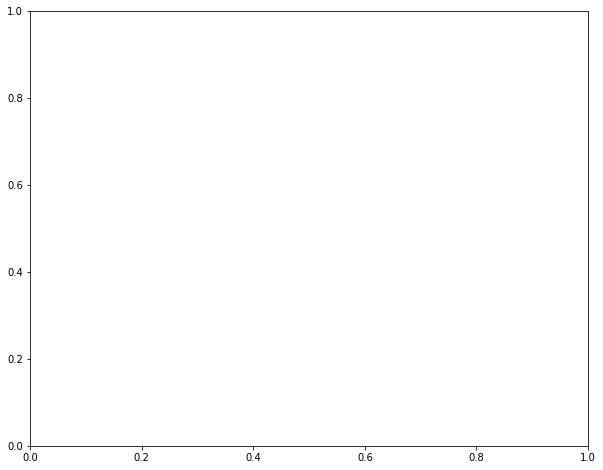

In [9]:
# troubleshooting above test# test of model w/ varying sigma
T = 20
dt = 0.01
trange = np.array([0, T])
#tvals = np.arange(0, T + dt, dt)
tvals = np.linspace(0, T, 2000)
n_of_ic = 30
feature_count = 2
fig, axs = plt.subplots(figsize=(10,8))
netswitch_x0s = (np.random.rand(n_of_ic, feature_count) * 5)
sigma = 0.01
sigma_list = np.linspace(0.001, 0.6, 20)
mu = np.zeros(feature_count)
sparse_regression_optimizer = ps.STLSQ(threshold=0.5)
netswitch_train_multi = []
integrator_keywords = {}
# 0 for white, 1 for pink, 2 for brown
beta = 0
#integrator_keywords['full_output'] = True
#integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
#integrator_keywords['atol'] = 1e-12

print(integrator_keywords)

# creation of TRUE data/solution
for i in range(n_of_ic):     
    netswitch_train_temp = solve_ivp(
        netswitch, trange, netswitch_x0s[i], t_eval=tvals
    ).y.T
    netswitch_train_multi.append(netswitch_train_temp)
print(len(netswitch_train_multi))
print(netswitch_train_multi[0].shape)
# may need to use np.zeros
rmse = np.sqrt(np.square(netswitch_train_multi).sum()) / (len(tvals) * feature_count)
print(f"RMSE = {rmse}")
print(netswitch_x0s)

0.001
(u)' = -0.965 u + -2.228 1/(1 + u^1) + 39.040 1/(1 + u^2) + -3.774 1/(1 + v^2) + -97.393 1/(1 + u^3) + 3.865 1/(1 + v^3) + 95.521 1/(1 + u^4) + -0.849 1/(1 + v^4) + -33.265 1/(1 + u^5)
(v)' = -0.979 v + 2.536 1/(1 + u^1) + 11.344 1/(1 + v^1) + -2.822 1/(1 + u^2) + -72.003 1/(1 + v^2) + 160.722 1/(1 + v^3) + 1.684 1/(1 + u^4) + -154.810 1/(1 + v^4) + 54.317 1/(1 + v^5)
[2.02509684 3.00322762]
[3.76202857 2.18043422]
[2.5667126  2.18684537]
[0.31497897 3.80047259]
[0.75834496 1.36487447]
[2.45842811 1.43859345]
[1.44206144 0.49745614]
[1.30406876 1.95030417]
[2.06108279 1.81331975]
[1.95428241 3.69742737]
[3.62438987 2.64272581]
[1.23739272 2.27084102]
[0.68504378 0.09415168]
[2.14858937 1.13850504]
[3.02416868 2.4618377 ]
[0.13497447 0.96337779]
[3.30529246 4.60109906]
[0.78247674 1.06464271]
[4.59193883 4.56665017]
[0.98168913 0.42179265]
[2.62938407 3.60267814]
[0.6397077  1.61352554]
[1.36425646 0.15345143]
[3.08006486 1.07850664]
[0.67606689 1.27723107]
[4.30417165 2.98725445]

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[2.14858937 1.13850504]
[3.02416868 2.4618377 ]
[0.13497447 0.96337779]
[3.30529246 4.60109906]
[0.78247674 1.06464271]
[4.59193883 4.56665017]
[0.98168913 0.42179265]
[2.62938407 3.60267814]
[0.6397077  1.61352554]
[1.36425646 0.15345143]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[3.08006486 1.07850664]
[0.67606689 1.27723107]
[4.30417165 2.98725445]
[3.16202148 4.59051787]
[2.9953268  1.61409867]
[4.02420051 3.45458634]
[3.21183432 1.42490988]
List for sigma=0.19015789473684208: [0.006955213707520929, 0.09245692292161539, 0.19567288261280327, 0.1318310241574493, 0.17488449289923327, 6.829428457580093, 1.8291053066053333]
0.22168421052631576
(u)' = 0.897 1/(1 + u^1) + 3.549 1/(1 + u^2) + -4.320 1/(1 + u^3) + -2.706 1/(1 + u^4) + 2.736 1/(1 + u^5)
(v)' = -0.668 u + 1.516 1/(1 + u^1) + 5.650 1/(1 + u^2) + 5.415 1/(1 + v^2) + -18.137 1/(1 + u^3) + -3.900 1/(1 + v^3) + -12.219 1/(1 + u^4) + -6.181 1/(1 + v^4) + 22.578 1/(1 + u^5) + 5.908 1/(1 + v^5)
[2.02509684 3.00322762]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[3.76202857 2.18043422]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[2.5667126  2.18684537]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.31497897 3.80047259]
[0.75834496 1.36487447]
[2.45842811 1.43859345]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[1.44206144 0.49745614]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[1.30406876 1.95030417]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[2.06108279 1.81331975]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[1.95428241 3.69742737]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[3.62438987 2.64272581]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[1.23739272 2.27084102]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.68504378 0.09415168]
[2.14858937 1.13850504]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[3.02416868 2.4618377 ]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.13497447 0.96337779]
[3.30529246 4.60109906]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.78247674 1.06464271]
[4.59193883 4.56665017]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.98168913 0.42179265]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[2.62938407 3.60267814]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.6397077  1.61352554]
[1.36425646 0.15345143]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[3.08006486 1.07850664]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.67606689 1.27723107]
[4.30417165 2.98725445]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[3.16202148 4.59051787]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[2.9953268  1.61409867]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[4.02420051 3.45458634]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[3.21183432 1.42490988]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


List for sigma=0.22168421052631576: [0.006955213707520929, 0.09245692292161539, 0.19567288261280327, 0.1318310241574493, 0.17488449289923327, 6.829428457580093, 1.8291053066053333, 0.4122520163228721]
0.25321052631578944
(u)' = -0.967 1/(1 + u^1) + 0.674 1/(1 + v^1) + -7.742 1/(1 + u^2) + -4.171 1/(1 + v^2) + 10.577 1/(1 + u^3) + 2.211 1/(1 + v^3) + 10.570 1/(1 + u^4) + 8.360 1/(1 + v^4) + -12.787 1/(1 + u^5) + -7.118 1/(1 + v^5)
(v)' = -1.439 1/(1 + u^3) + 1.577 1/(1 + v^3) + -1.078 1/(1 + u^4) + 1.069 1/(1 + v^4) + 2.451 1/(1 + u^5) + -2.578 1/(1 + v^5)
[2.02509684 3.00322762]
[3.76202857 2.18043422]
[2.5667126  2.18684537]
[0.31497897 3.80047259]
[0.75834496 1.36487447]
[2.45842811 1.43859345]
[1.44206144 0.49745614]
[1.30406876 1.95030417]
[2.06108279 1.81331975]
[1.95428241 3.69742737]
[3.62438987 2.64272581]
[1.23739272 2.27084102]
[0.68504378 0.09415168]
[2.14858937 1.13850504]
[3.02416868 2.4618377 ]
[0.13497447 0.96337779]
[3.30529246 4.60109906]
[0.78247674 1.06464271]
[4.591

C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.31497897 3.80047259]
[0.75834496 1.36487447]
[2.45842811 1.43859345]
[1.44206144 0.49745614]
[1.30406876 1.95030417]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[2.06108279 1.81331975]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[1.95428241 3.69742737]
[3.62438987 2.64272581]
[1.23739272 2.27084102]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.68504378 0.09415168]
[2.14858937 1.13850504]
[3.02416868 2.4618377 ]
[0.13497447 0.96337779]
[3.30529246 4.60109906]
[0.78247674 1.06464271]
[4.59193883 4.56665017]
[0.98168913 0.42179265]
[2.62938407 3.60267814]
[0.6397077  1.61352554]
[1.36425646 0.15345143]
[3.08006486 1.07850664]
[0.67606689 1.27723107]
[4.30417165 2.98725445]
[3.16202148 4.59051787]
[2.9953268  1.61409867]


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[4.02420051 3.45458634]
[3.21183432 1.42490988]
List for sigma=0.3162631578947368: [0.006955213707520929, 0.09245692292161539, 0.19567288261280327, 0.1318310241574493, 0.17488449289923327, 6.829428457580093, 1.8291053066053333, 0.4122520163228721, 2.5592465216964606, 0.48098181071843293, 5.136240016817402]
0.3477894736842105
(u)' = 0.727 v + -2.203 1/(1 + u^1) + 6.123 1/(1 + v^1) + -13.816 1/(1 + u^2) + 4.038 1/(1 + v^2) + 14.129 1/(1 + u^3) + -27.763 1/(1 + v^3) + 12.848 1/(1 + u^4) + 2.214 1/(1 + v^4) + -12.531 1/(1 + u^5) + 15.631 1/(1 + v^5)
(v)' = -1.028 1/(1 + u^1) + -2.848 1/(1 + v^1) + 2.122 1/(1 + u^2) + -9.939 1/(1 + v^2) + 3.083 1/(1 + u^3) + 14.092 1/(1 + v^3) + -2.445 1/(1 + u^4) + 5.900 1/(1 + v^4) + -9.202 1/(1 + v^5)
[2.02509684 3.00322762]
[3.76202857 2.18043422]
[2.5667126  2.18684537]
[0.31497897 3.80047259]
[0.75834496 1.36487447]
[2.45842811 1.43859345]
[1.44206144 0.49745614]
[1.30406876 1.95030417]
[2.06108279 1.81331975]
[1.95428241 3.69742737]
[3.62438987 2.642

[2.06108279 1.81331975]
[1.95428241 3.69742737]
[3.62438987 2.64272581]
[1.23739272 2.27084102]
[0.68504378 0.09415168]
[2.14858937 1.13850504]
[3.02416868 2.4618377 ]
[0.13497447 0.96337779]
[3.30529246 4.60109906]
[0.78247674 1.06464271]
[4.59193883 4.56665017]
[0.98168913 0.42179265]
[2.62938407 3.60267814]
[0.6397077  1.61352554]
[1.36425646 0.15345143]
[3.08006486 1.07850664]
[0.67606689 1.27723107]
[4.30417165 2.98725445]
[3.16202148 4.59051787]
[2.9953268  1.61409867]
[4.02420051 3.45458634]
[3.21183432 1.42490988]
List for sigma=0.5054210526315789: [0.006955213707520929, 0.09245692292161539, 0.19567288261280327, 0.1318310241574493, 0.17488449289923327, 6.829428457580093, 1.8291053066053333, 0.4122520163228721, 2.5592465216964606, 0.48098181071843293, 5.136240016817402, 2.603137111025691, 5.820872519435047, 6.042241241137343, 8.604986567941536, 54919.81835851455, 7.752806192075716]
0.5369473684210525
(u)' = -1.333 1/(1 + u^1) + 1.173 1/(1 + v^1) + -7.122 1/(1 + u^2) + 5.296 1/(1

Text(0.5, 0.98, 'Mean Squared Error vs. Standard Deviation in Gaussian Noise')

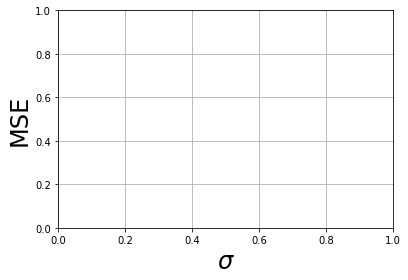

In [26]:
# troubleshoot/debug
# train models
MSE_list = []
for j in range(len(sigma_list)):
    sigma = np.zeros((feature_count, feature_count))
    sigmaVal = sigma_list[j]
    np.fill_diagonal(sigma, sigmaVal)
    print(sigmaVal)
    #noise = np.random.multivariate_normal(mu, sigma**2, (n_of_ic, len(tvals)))
    noise = cn.powerlaw_psd_gaussian(beta, (n_of_ic, len(tvals), feature_count)) * (sigmaVal + 0.03)
    model = ps.SINDy(feature_names=['u', 'v'], optimizer=sparse_regression_optimizer, feature_library=netswitch_library)
    model.fit(list(netswitch_train_multi + noise), t=dt, multiple_trajectories=True)
    model.print()
    simulations = []
    # create simulations list to hold simulated data for corresponding IC
    for k in range(n_of_ic):
        # problem area with warnings
        print(netswitch_x0s[k])
        netswitch_sim = model.simulate(netswitch_x0s[k], t=tvals, integrator="odeint", integrator_kws=integrator_keywords)
        simulations.append(netswitch_sim) 
    MSE = np.square(np.subtract(netswitch_train_multi, simulations)).sum() / (len(tvals) * feature_count * n_of_ic)
    MSE_list.append(MSE)
    print(f"List for sigma={sigmaVal}: {MSE_list}")
print(sigma_list)
print(MSE_list)
axs.plot(sigma_list, MSE_list)
axs.set(xlabel="$\sigma$", ylabel="MSE")
plt.grid(True)
plt.xlabel("$\sigma$", fontsize=24)
plt.ylabel("MSE", fontsize=24)
fig.suptitle('Mean Squared Error vs. Standard Deviation in Gaussian Noise', fontsize=28)
#plt.yscale('log')

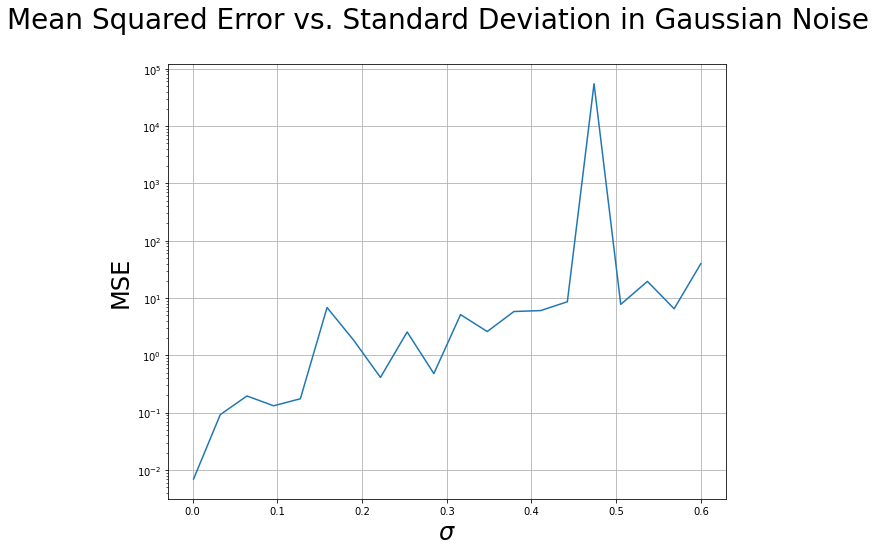

In [29]:
fig, axs = plt.subplots(figsize=(10,8))
axs.plot(sigma_list, MSE_list)
axs.set(xlabel="$\sigma$", ylabel="MSE")
plt.grid(True)
plt.xlabel("$\sigma$", fontsize=24)
plt.ylabel("MSE", fontsize=24)
fig.suptitle('Mean Squared Error vs. Standard Deviation in Gaussian Noise', fontsize=28)
plt.yscale('log')

In [25]:
print(len(simulations))
MSE = np.square(np.subtract(netswitch_train_multi, simulations)).sum() / (len(tvals) * feature_count * n_of_ic)
print(MSE)
print(len(MSE_list))

30
14.647031398387892
20


500
(500, 2)


C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\UserALai\miniconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
[37.3578045243963, 36.37379970329704, 29.841768973750906, 27.676998815722346, 26.937230446945765, 33.23314990542521, 28.331078676135323, 36.061445615625104, 33.96751323446484, 33.07196064090767, 33.496691804194015, 33.00569735154315, 32.235021649114294, 33.119658136402556, 29.076400317310586, 33.83599033230518, 34.974040063692, 28.676922708877836, 234.49789074432988, 33.40674281423231]


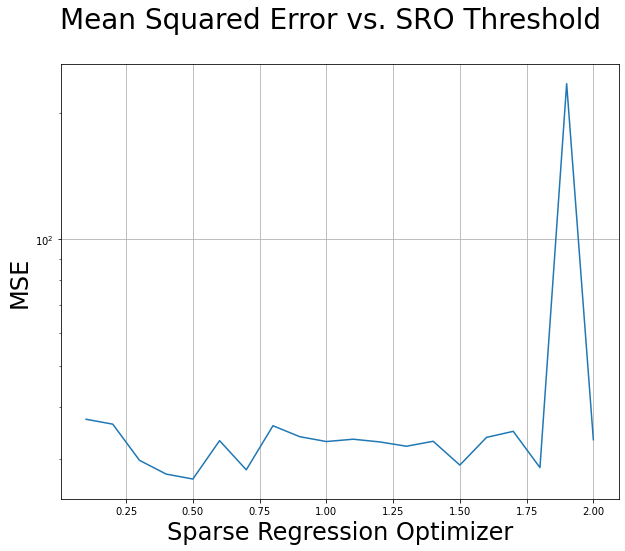

In [70]:
# test of model w/ varying threshold
# edit in progress
T = 50
dt = 0.01
trange = np.array([0, T])
#tvals = np.arange(0, T + dt, dt)
tvals = np.linspace(0, T, 500)
n_of_ic = 500
feature_count = 2
fig, axs = plt.subplots(figsize=(10,8))
netswitch_x0s = (np.random.rand(n_of_ic, feature_count) * 5 - np.random.rand(n_of_ic, feature_count))
#sigma = 0.01
threshold_list = np.linspace(0.1, 2, 20)
mu = np.zeros(feature_count)

MSE_list = []
netswitch_train_multi = []

# creation of TRUE data/solution
for i in range(n_of_ic):
    netswitch_train_temp = solve_ivp(
        netswitch, trange, netswitch_x0s[i], t_eval=tvals
    ).y.T
    netswitch_train_multi.append(netswitch_train_temp)
print(len(netswitch_train_multi))
print(netswitch_train_multi[0].shape)
sigma = np.zeros((feature_count, feature_count))
sigmaVal = 0.2
np.fill_diagonal(sigma, sigmaVal)
# figure out sigma threshold with rmse for prev. cell 
# train models
for j in range(len(threshold_list)):
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold_list[j])
    model = ps.SINDy(feature_names=['u', 'v'], optimizer=sparse_regression_optimizer, feature_library=netswitch_library)
    noise = np.random.multivariate_normal(mu, sigma**2, (n_of_ic, len(tvals)))
    model.fit(list(netswitch_train_multi + noise), t=dt, multiple_trajectories=True)
    simulations = []
    # create simulations list to hold simulated data for corresponding IC
    for k in range(n_of_ic):
        netswitch_sim = model.simulate(netswitch_x0s[k], t=tvals, integrator="odeint")
        simulations.append(netswitch_sim) 
    #MSE = np.square(np.subtract(netswitch_train_multi, simulations)).mean()
    MSE = np.square(np.subtract(netswitch_train_multi, simulations)).sum() / (feature_count * len(tvals) * n_of_ic)
    MSE_list.append(MSE)
print(threshold_list)
print(MSE_list)
axs.plot(threshold_list, MSE_list)
axs.set(xlabel="Sparse Regression Optimizer", ylabel="MSE")
plt.grid(True)
plt.xlabel("Sparse Regression Optimizer", fontsize=24)
plt.ylabel("MSE", fontsize=24)
fig.suptitle('Mean Squared Error vs. SRO Threshold', fontsize=28)
plt.savefig("C:/Users/UserALai/Downloads\img.svg", bbox_inches='tight')
plt.yscale('log')

## Repressilator/Gene Network Clock

In [6]:
# General from of equations; reference pg 112
# mdot_i = -m_i + (alpha / (1+p_j**n)) + a0
# pdot_i = -beta * (p_i - m_i)
# if i = lacI, tetR, cl
# then j = cl, lacI, tetR

# is there a better way of doing this? kinda spaghetti code 
#mdot_lacI = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -m_lacI + (alpha / (1+p_cl**n)) + a0
#mdot_tetR = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -m_tetR + (alpha / (1+p_lacI**n)) + a0
#mdot_cl = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -m_cl + (alpha / (1+p_tetR**n)) + a0
#pdot_lacI = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -beta * (p_lacI - m_lacI)
#pdot_tetR = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -beta * (p_tetR - m_tetR)
#pdot_cl = lambda m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl: -beta * (p_cl - m_cl)

alpha=50
a0=0
n=2
beta=0.2
# x in form:
# [m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl]
# [0     , 1     , 2   , 3     , 4     , 5   ]
def repressilator(t, x):
    return [
        -x[0] + (alpha / (1 + x[5]**n)) + a0,
        -x[1] + (alpha / (1+x[3]**n)) + a0,
        -x[2] + (alpha / (1+x[4]**n)) + a0,
        -beta * (x[3] - x[0]),
        -beta * (x[4] - x[1]),
        -beta * (x[5] - x[2])
    ]

T = 300
dt = 0.01
trange = np.array([0, T])
tvals = np.arange(0, T + dt, dt)
x0 = np.array([0.2, 0.1, 0.3, 0.1, 0.4, 0.5])
x_train1 = solve_ivp(repressilator, trange, x0, t_eval=tvals).y

alpha=50
a0=1
n=2
beta=0.2
#T=100
trange2 = np.array([0, T])
tvals2 = np.arange(0, T + dt, dt)

x_train2 = solve_ivp(repressilator, trange2, x0, t_eval=tvals2).y
"""
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].plot(tvals, x_train1[0, ], "r", label="$m_{lacI}$",)
axs[0].plot(tvals, x_train1[1, :], "g", label="$m_{tetR}$")
axs[0].plot(tvals, x_train1[2, :], "b", label="$m_{cl}$")
axs[0].plot(tvals, x_train1[3, :], "r--", label="$p_{lacI}$")
axs[0].plot(tvals, x_train1[4, :], "g--", label="$p_{tetR}$")
axs[0].plot(tvals, x_train1[5, :], "b--", label="$p_{cl}$")

axs[0].legend()
axs[0].set(xlabel="t", title="Oscillatory Repressilator solutions")

axs[1].plot(tvals2, x_train2[0, ], "r", label="$m_{lacI}$",)
axs[1].plot(tvals2, x_train2[1, :], "g", label="$m_{tetR}$")
axs[1].plot(tvals2, x_train2[2, :], "b", label="$m_{cl}$")
axs[1].plot(tvals2, x_train2[3, :], "r--", label="$p_{lacI}$")
axs[1].plot(tvals2, x_train2[4, :], "g--", label="$p_{tetR}$")
axs[1].plot(tvals2, x_train2[5, :], "b--", label="$p_{cl}$")

axs[1].legend()
axs[1].set(xlabel="t", title="Convergent Repressilator solutions")
"""

'\nfig, axs = plt.subplots(1, 2, figsize=(20, 8))\naxs[0].plot(tvals, x_train1[0, ], "r", label="$m_{lacI}$",)\naxs[0].plot(tvals, x_train1[1, :], "g", label="$m_{tetR}$")\naxs[0].plot(tvals, x_train1[2, :], "b", label="$m_{cl}$")\naxs[0].plot(tvals, x_train1[3, :], "r--", label="$p_{lacI}$")\naxs[0].plot(tvals, x_train1[4, :], "g--", label="$p_{tetR}$")\naxs[0].plot(tvals, x_train1[5, :], "b--", label="$p_{cl}$")\n\naxs[0].legend()\naxs[0].set(xlabel="t", title="Oscillatory Repressilator solutions")\n\naxs[1].plot(tvals2, x_train2[0, ], "r", label="$m_{lacI}$",)\naxs[1].plot(tvals2, x_train2[1, :], "g", label="$m_{tetR}$")\naxs[1].plot(tvals2, x_train2[2, :], "b", label="$m_{cl}$")\naxs[1].plot(tvals2, x_train2[3, :], "r--", label="$p_{lacI}$")\naxs[1].plot(tvals2, x_train2[4, :], "g--", label="$p_{tetR}$")\naxs[1].plot(tvals2, x_train2[5, :], "b--", label="$p_{cl}$")\n\naxs[1].legend()\naxs[1].set(xlabel="t", title="Convergent Repressilator solutions")\n'

## Morris-Lecar Model
    

[Text(0.5, 0, 't'), Text(0.5, 1.0, 'Morris-Lecar solutions')]

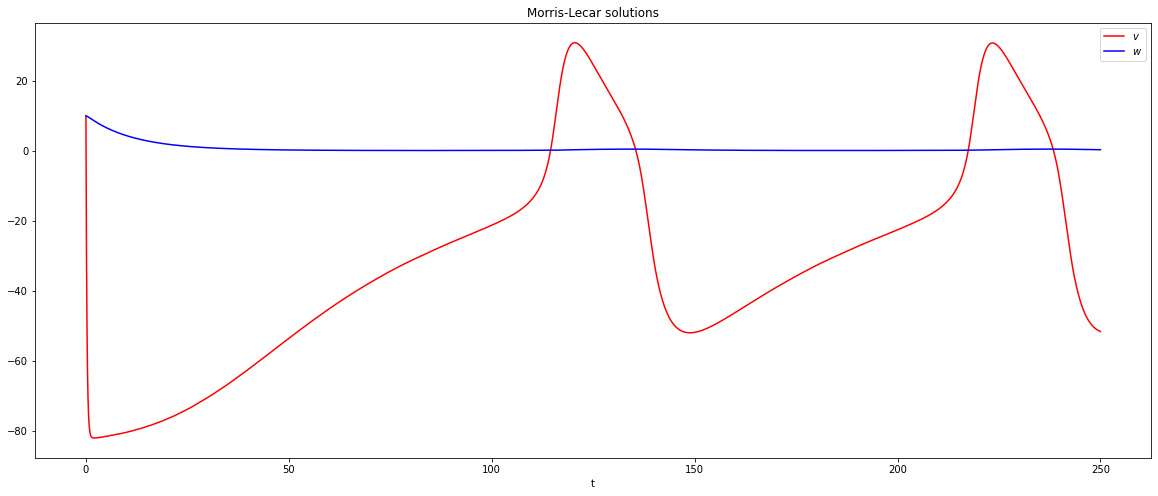

In [5]:
gCa, gK, gL, vCa, vK, vL, C, phi, i, v_1, v_2, v_3, v_4 = 4.4, 8, 2, 120, -84, -60, 20, 0.04, 90, -1.2, 18, 2, 30
# helper functions v ^ parameters
m_inf = lambda v: 0.5 * (1 + np.tanh((v - v_1) / v_2))
w_inf = lambda v: 0.5 * (1 + np.tanh((v - v_3) / v_4))
t_w = lambda v: 1 / (np.cosh((v-v_3) / (2 * v_4)))

# x = [v, w]
def morris_lecar(t, x):
    return [
        (1/C) * (i-gCa * m_inf(x[0]) * (x[0] - vCa)-gK * x[1] * (x[0]-vK) - gL * (x[0]-vL)),
        (1/t_w(x[0])) * (phi * (w_inf(x[0]) - x[1]))
    ]

T = 250
dt = 0.01
trange = np.array([0, T])
tvals = np.arange(0, T + dt, dt)
x0 = np.array([10, 10])

MorLec_train = solve_ivp(morris_lecar, trange, x0, t_eval=tvals).y

fig, axs = plt.subplots(figsize=(20, 8))
axs.plot(tvals, MorLec_train[0, ], "r", label="$v$")
axs.plot(tvals, MorLec_train[1, ], "b", label="$w$")


axs.legend()
axs.set(xlabel="t", title="Morris-Lecar solutions")

In [6]:
gCa, gK, gL, vCa, vK, vL, C, phi, i, v_1, v_2, v_3, v_4 = 4.4, 8, 2, 120, -84, -60, 20, 0.04, 90, -1.2, 18, 2, 30
# helper functions v ^ parameters
m_inf = lambda v: 0.5 * (1 + np.tanh((v - v_1) / v_2))
w_inf = lambda v: 0.5 * (1 + np.tanh((v - v_3) / v_4))
t_w = lambda v: 1 / (np.cosh((v-v_3) / (2 * v_4)))

# x = [v, w]
def morris_lecar(t, x):
    return [
        (1/C) * (i-gCa * m_inf(x[0]) * (x[0] - vCa)-gK * x[1] * (x[0]-vK) - gL * (x[0]-vL)),
        (1/t_w(x[0])) * (phi * (w_inf(x[0]) - x[1]))
    ]

# morris-lecar library functions
library_functions = [
    lambda x: x,
    lambda x: 1 / (1 + x**1),
    lambda x: 1 / (1 + x**2),
    lambda x: 1 / (1 + x**3),
    lambda x: 1 / (1 + x**4),
    lambda x: 1 / (1 + x**5)
]
library_function_names = [
    lambda x: x,
    lambda x: '1/(1 + ' + x + '^1)',
    lambda x: '1/(1 + ' + x + '^2)',
    lambda x: '1/(1 + ' + x + '^3)',
    lambda x: '1/(1 + ' + x + '^4)',
    lambda x: '1/(1 + ' + x + '^5)'
]
netswitch_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

In [ ]:
# actual test of model
T = 250
dt = 0.01
trange = np.array([0, T])
#tvals = np.arange(0, T + dt, dt)
tvals = np.linspace(0, T, 100)
n_of_ic = 500
feature_count = 2
fig, axs = plt.subplots(figsize=(10,8))
netswitch_x0s = (np.random.rand(n_of_ic, feature_count) * 10 - np.random.rand(n_of_ic, feature_count))
sigma = 0.01
sigma_list = np.linspace(0.001, 0.6, 5)
mu = np.zeros(feature_count)

MSE_list = []
morlec_train_multi = []

# creation of TRUE data/solution
for i in range(n_of_ic):     
    morlec_train_temp = solve_ivp(
        netswitch, trange, netswitch_x0s[i], t_eval=tvals
    ).y.T
    netswitch_train_multi.append(netswitch_train_temp)
print(len(netswitch_train_multi))
print(netswitch_train_multi[0].shape)

# train models
for j in range(len(sigma_list)):
    sigma = np.zeros((feature_count, feature_count))
    sigmaVal = sigma_list[j]
    np.fill_diagonal(sigma, sigmaVal)
    noise = np.random.multivariate_normal(mu, sigma**2, (n_of_ic, len(tvals)))
    model = ps.SINDy(feature_names=['u', 'v'], optimizer=sparse_regression_optimizer, feature_library=netswitch_library)
    model.fit(list(netswitch_train_multi + noise), t=dt, multiple_trajectories=True)
    simulations = []
    # create simulations list to hold simulated data for corresponding IC
    for k in range(n_of_ic):
        netswitch_sim = model.simulate(netswitch_x0s[k], t=tvals, integrator="odeint")
        simulations.append(netswitch_sim) 
    MSE = np.square(np.subtract(netswitch_train_multi, simulations)).mean()
    MSE_list.append(MSE)
print(sigma_list)
print(MSE_list)
axs.plot(sigma_list, MSE_list)
axs.set(xlabel="$\sigma$", ylabel="MSE", title="Mean Squared Error vs. Standard Deviation in Gaussian Noise")
plt.grid(True)
plt.xlabel("$\sigma$", fontsize=24)
plt.ylabel("MSE", fontsize=24)
fig.suptitle('Mean Squared Error vs. Standard Deviation in Gaussian Noise', fontsize=28)